# Comparison of regression models for predicting boat residuary resistance based on existing model basin data

## Softuni.bg Machine Learning Feb 2018 course project

## Ognian Dantchev

## Abstract

The purpose of the study is to compare classic machine learning algorithms, applicable to a regression problem in the field of yacht hydrodynamics.  The model created is suitable for quick/rough estimation of the boat resistance in the initial design stage, saving time and resources from CFD simulation or scale model testing.  Results are compared to models based on Artificial neural networks.  A model based on Multivariate Adaptive Regression Splines (MARS) was found to be most suitable for predicting the boat residuary resistance from the existing data set.

# Introduction

Prediction of residuary resistance of sailing yachts at the initial design stage is of a great value for evaluating the ship's performance and for estimating the required propulsive power. Essential inputs include the basic hull dimensions and the boat velocity. 

The Delft data set comprises 308 full-scale experiments, which were performed at the Delft Ship Hydromechanics Laboratory of the Delft University of Technology. 
These experiments include 22 different hull forms, derived from a parent form closely related to the Standfast 43 boat, [http://sailboatdata.com/viewrecord.asp?class_id=4810]

The source of the __Yacht Hydrodynamics Data Set__, [\[0\]](#references), is the UCI Machine Learning Repository.  


![Fig.1](sys1.png)
Fig. 1:  Linesplan Sysser 1, base model for series 1 of Delft Systematic Yacht Hull Series


Attribute Information:

Variations concern hull geometry coefficients and the Froude number: 

1. Longitudinal position of the center of buoyancy, adimensional; 
2. Prismatic coefficient $C_P$, adimensional;
3. Length-displacement ratio, adimensional;
4. Beam-draught ratio, adimensional; 
5. Length-beam ratio, adimensional;
6. Froude number $Fr$, [1], adimensional;
7. Residuary resistance $C_R$, [2], per unit weight of displacement, adimensional. (The measured variable and target  we'll try to predict using regression models)

The measurement data in the set is from model tests of the Delft Systematic Yacht Hull Series (DSYHS). This series has been started in 1973 by professor J. Gerritsma of TU Delft, in cooperation with N. Newman and J. Kerwin of the Massachusetts Institute of Technology (MIT). 


To interpret the geometry of the boat, the physics of the problem, the variables and the results, these refereces are a good starting point: [\[1, 2, 3, 6, 10\]](#references) .

Most of the variables are geometric features and adimensional geometric coefficients.  So we can expect some redundancy and __Multicollinearity__ in the data.

The most important one is the __Froude number__ ($Fr$) [\[1\]](#references), as it includes the velocity.  The Froude number is a dimensionless number defined as the ratio of the flow inertia to the external field (the latter in many applications simply due to gravity). Named after William Froude (/ˈfruːd/;[1]), the Froude number is based on the speed–length ratio which he defined as:

$ \mathrm {Fr} ={\frac {u_{0}}{\sqrt {g_{0}l_{0}}}}$

where $u_{0}$ is a characteristic flow velocity, $g_{0}$ is in general a characteristic external field, and $l_{0}$ is a characteristic length.

The the Froude number ($Fr$)  is widely used in ship hydrodynamics and is close to the Mach number ($M$) and the other flow __Similarity Parameters__.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.interpolate as si
from scipy import stats

from sklearn.model_selection import train_test_split, GridSearchCV, \
                                    StratifiedShuffleSplit, ShuffleSplit, cross_val_predict
from sklearn.metrics import average_precision_score, make_scorer, mean_squared_error

from sklearn.linear_model import LinearRegression, RANSACRegressor,\
                                 TheilSenRegressor, HuberRegressor,\
                                 Ridge, BayesianRidge, Lasso
        
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler

from sklearn.base import TransformerMixin
from sklearn.pipeline import make_pipeline

from pyearth import Earth
# py-earth is a Python implementation of Jerome Friedman's Multivariate Adaptive Regression Splines (MARS) that 
# works OK with SciKit-learn. To install (requires numpy and sklearn):
#    git clone git://github.com/scikit-learn-contrib/py-earth.git
#    cd py-earth
#    sudo python setup.py install
#
#    This is Python only and works on both GNU/Linux and MacOS. 
#
# https://pypi.python.org/pypi/sklearn-contrib-py-earth/0.1.0



In [2]:
%matplotlib inline

In [3]:
column_names = ["center_of_buoyancy", "prismatic_coefficient", "length_displacement", 
                            "beam_draught_ratio", "length_beam_ratio", "froude_number", "resistance"]

In [4]:
yacht = pd.read_fwf("yacht_hydrodynamics.data", header= None, 
                    names= ["center_of_buoyancy", "prismatic_coefficient", "length_displacement", 
                            "beam_draught_ratio", "length_beam_ratio", "froude_number", "resistance"]) 
                    #names= column_names

In [5]:
yacht.dtypes

center_of_buoyancy       float64
prismatic_coefficient    float64
length_displacement      float64
beam_draught_ratio       float64
length_beam_ratio        float64
froude_number            float64
resistance               float64
dtype: object

In [6]:
# there's one parasitic line at the bottom -- remove it 
yacht = yacht.drop(308)

In [7]:
yacht.head()

,center_of_buoyancy,prismatic_coefficient,length_displacement,beam_draught_ratio,length_beam_ratio,froude_number,resistance
0,-2.3,0.568,4.78,3.99,3.17,0.125,0.11
1,-2.3,0.568,4.78,3.99,3.17,0.150,0.27
2,-2.3,0.568,4.78,3.99,3.17,0.175,0.47
3,-2.3,0.568,4.78,3.99,3.17,0.200,0.78
4,-2.3,0.568,4.78,3.99,3.17,0.225,1.18


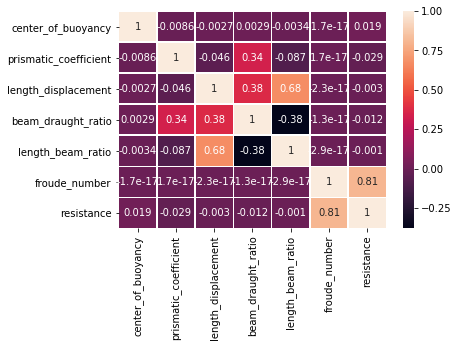

In [8]:
sns.heatmap(yacht.corr(), linewidths=.5, annot= True)
plt.show()

A strong correlation of $Fr$ can be observed, but for the completeness of the model two of the geometry based variables can be included.


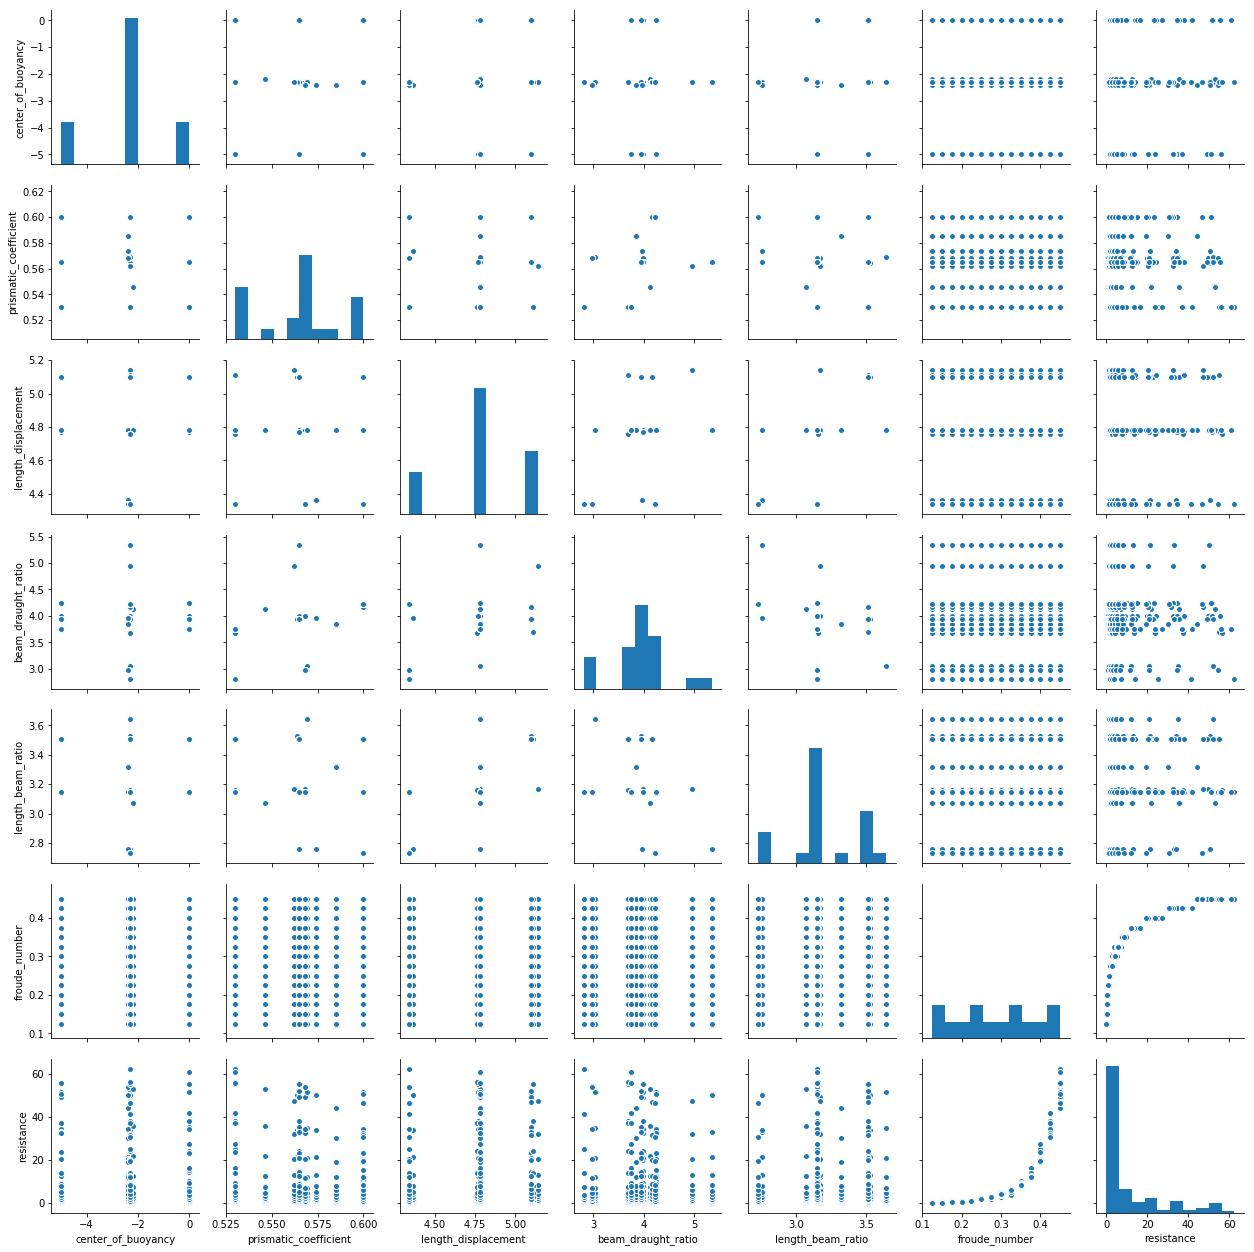

In [9]:
# seaborn pairplot for all variable couples:
sns.pairplot(yacht)
plt.show()

#kind="reg"


As expected, the Froude number $Fr$ exhibits strong relation to the target variable, the resistance.  The data for this variable seems quite smooth, i.e. no need for logarithmic transformation.


Most of the geometric variables are in "steps" due to the geometry variations of the hull series tested.  There will be some multicollinearity as expected.


The relation however is obviously not linear.  A couple of assumptions can be made, that we'll need to verify later on:
1. Linear models will not give good results;
2. Ensemble methods will be more suitable.

Polynomial features for the linear models might help, but they have some constraints [\[4\]](#references) and are quickly being replaces by B-spline features.  I would try a model based on Multivariate adaptive regression splines (MARS): a form of regression analysis introduced by Jerome H. Friedman in 1991  
(Multivariate adaptive regression splines, From Wikipedia https://en.wikipedia.org/wiki/Multivariate_adaptive_regression_splines
).

MARS is a non-parametric regression technique and can be seen as an extension of linear models that __automatically models nonlinearities and interactions between variables__.


A suitable metric to compare the regression models would be __mean squared error (MSE)__.



In [10]:
yacht.describe()

,center_of_buoyancy,prismatic_coefficient,length_displacement,beam_draught_ratio,length_beam_ratio,froude_number,resistance
count,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000
mean,-2.381818,0.564136,4.788636,3.936818,3.206818,0.287500,10.495357
std,1.513219,0.023290,0.253057,0.548193,0.247998,0.100942,15.160490
min,-5.000000,0.530000,4.340000,2.810000,2.730000,0.125000,0.010000
25%,-2.400000,0.546000,4.770000,3.750000,3.150000,0.200000,0.777500
50%,-2.300000,0.565000,4.780000,3.955000,3.150000,0.287500,3.065000
75%,-2.300000,0.574000,5.100000,4.170000,3.510000,0.375000,12.815000
max,0.000000,0.600000,5.140000,5.350000,3.640000,0.450000,62.420000


In [11]:
yacht_null_data = yacht[yacht.isnull().any(axis=1)]

In [12]:
yacht_null_data

,center_of_buoyancy,prismatic_coefficient,length_displacement,beam_draught_ratio,length_beam_ratio,froude_number,resistance


The data is OK; there were no missing values or errors.

## Scaling

Most of the variables are dimensionless geometric features of the boat hull.  I don't think they need much scaling.
In [\[9\]](#references) however, they do scaling.

I'm a little concerned to see 0 to the 6th digit for resistance min -- it's not zero in the original set.

It is worth comparing the results with and w/o scaling.



In [13]:

scaler = MinMaxScaler()

scaler.fit(yacht)

yacht_scaled= scaler.transform(yacht)

#now this is an NumPy array -- need to convert it back to pd dataframe"
yacht_scaled = pd.DataFrame(yacht_scaled, columns= column_names)

In [14]:
yacht_scaled.describe()

,center_of_buoyancy,prismatic_coefficient,length_displacement,beam_draught_ratio,length_beam_ratio,froude_number,resistance
count,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000
mean,0.523636,0.487662,0.560795,0.443629,0.523976,0.500000,0.168008
std,0.302644,0.332714,0.316321,0.215824,0.272526,0.310591,0.242918
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.520000,0.228571,0.537500,0.370079,0.461538,0.230769,0.012298
50%,0.540000,0.500000,0.550000,0.450787,0.461538,0.500000,0.048950
75%,0.540000,0.628571,0.950000,0.535433,0.857143,0.769231,0.205175
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:

#http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html



In [15]:
yacht_scaled
yacht_scaled["froude_number"].loc[294]

0.0

Not sure if these zeros make sense -- especially if we want to reverse the scaling for physical interpretation of the results.

Will drop the normalization for now.

In [16]:
X = yacht.drop(['resistance'], axis=1) 
Y = yacht['resistance']

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

sX_train, sX_test, sY_train, sY_test = train_test_split(yacht_scaled.drop(['resistance'], axis=1),
                                        yacht_scaled['resistance'], test_size=0.3, random_state=42)

In [18]:
# Model 1: Linear Regression
m1_lr = LinearRegression()
m1_lr.fit(X_train, Y_train)
# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
predicted_m1 = cross_val_predict(m1_lr, X_test, Y_test, cv=10)


In [19]:
Y.shape

(308,)

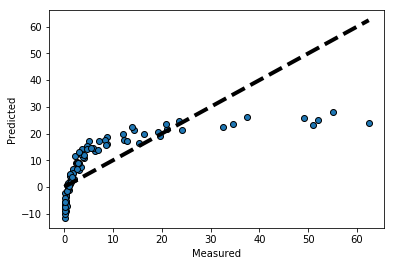

In [20]:

fig, ax = plt.subplots()
ax.scatter(Y_test, predicted_m1, edgecolors=(0, 0, 0))
ax.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [21]:
accuracy_score = m1_lr.score(X_test, Y_test)
print(accuracy_score)

0.571647920387


In [22]:
# Model 2: BayesianRidge
m2_br = BayesianRidge()
m2_br.fit(X_train, Y_train)
predicted_m2 = cross_val_predict(m2_br, X_test, Y_test, cv=10)

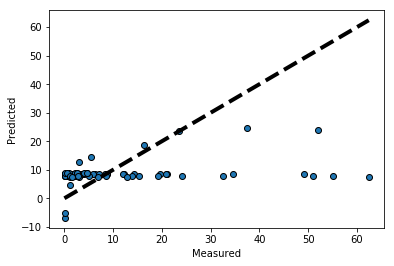

In [23]:
fig, ax = plt.subplots()
ax.scatter(Y_test, predicted_m2, edgecolors=(0, 0, 0))
ax.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [24]:
accuracy_score = m2_br.score(X_test, Y_test)
print(accuracy_score)

0.57482725733


In [25]:
# Scaled version of the Linear Regression, Model 1
sX_train, sX_test, sY_train, sY_test = train_test_split(yacht_scaled.drop(['resistance'], axis=1),
                                        yacht_scaled['resistance'], test_size=0.3, random_state=42)

In [26]:
sm1_lr = LinearRegression()
sm1_lr.fit(sX_train, sY_train)
# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
spredicted_m1 = cross_val_predict(sm1_lr, sX_test, sY_test, cv=10)

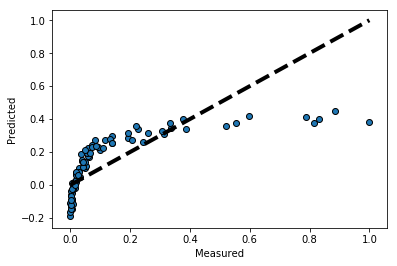

In [27]:
fig, ax = plt.subplots()
ax.scatter(sY_test, spredicted_m1, edgecolors=(0, 0, 0))
ax.plot([sY_test.min(), sY_test.max()], [sY_test.min(), sY_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [28]:
accuracy_score = sm1_lr.score(sX_test, sY_test)
print(accuracy_score)

0.571647920387


In [ ]:
# scaling had no effect on the accuracy

# Try some more linear: ridge, Bayesian ridge, lasso, 
# ensemble methods: DecisionTreeRegressor, RandomForestRegressor 
# and SVR

Least-Square
0.572807563617
 E=78

Ridge
0.557499309367
 E=80

BayesianRidge
0.575547185826
 E=77

Lasso
0.308301064152
 E=1.3e+02

Theil-Sen
0.571761792985
 E=78

RANSAC
0.180149500269
 E=1.5e+02

HuberRegressor
0.580968286151
 E=76



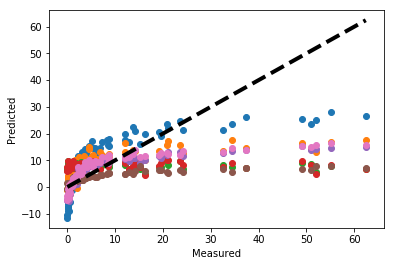

In [29]:
# Cycle most of the models in sklearn:

np.random.seed(42)


# predict y
#knots = np.linspace(-30, 30, 20)
#bspline_features = BSplineFeatures(knots, degree=3, periodic=False)

estimators = [('Least-Square', '-', 'C0', LinearRegression(fit_intercept=False)),
              ('Ridge', '-', 'C1', Ridge(fit_intercept=False)),
              ('BayesianRidge', '-', 'C2', BayesianRidge(fit_intercept=False)),
              ('Lasso', '-', 'C3', Lasso(fit_intercept=False)),
              ('Theil-Sen', '>', 'C4', TheilSenRegressor(random_state=42)),
              ('RANSAC', '<', 'C5', RANSACRegressor(random_state=42)),
              ('HuberRegressor', '--', 'C6', HuberRegressor())]


fig, ax = plt.subplots()

for label, style, color, estimator in estimators:

    model = estimator
    #model = make_pipeline(bspline_features, estimator)
    # B-spline pre-processor would be good, but I coud't find / re-work any that is more than 2D
    # see [4], [7], [12] and earth MARS model below
    model.fit(X_train, Y_train)
    
    mse = mean_squared_error(model.predict(X_test), Y_test)
    #y_predicted = model.predict(x_predict[:, None])
    predicted = cross_val_predict(model, X_test, Y_test, cv=10)
    accuracy_score = model.score(X_test, Y_test)
    
    ax.scatter(Y_test, predicted, edgecolors=color)
    
    print(label)
    print(accuracy_score)
    print(" E={:2.2g}".format(mse))
    print()

#ax.legend(loc='upper right', framealpha=0.95)
ax.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()


#plt.plot
#plt.scatter

As expected -- not good.  This should be a straight line.

Compare results after normalization?

In [30]:
# Epsilon-Support Vector Regression
m3_SVR = SVR()
m3_SVR.fit(X_train, Y_train)
# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
predicted_m3 = cross_val_predict(m3_SVR, X_test, Y_test, cv=10)


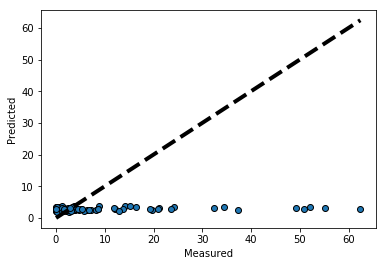

In [31]:
fig, ax = plt.subplots()
ax.scatter(Y_test, predicted_m3, edgecolors=(0, 0, 0))
ax.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [32]:
accuracy_score = m3_SVR.score(X_test, Y_test)
print(accuracy_score)

-0.0974826249739


In [45]:
mean_squared_error(predicted_m3, Y_test)

208.20907596145003

Nope, not at all...

In  [\[5\]](#references) they use stepwiselm() from MATLAB and [\[8, 9\]](#references) both use Artificial neural networks.

At this point I think I can skip the Cross Validation of the above linear methods and try other, that will give better initial result:

1. Ensemble method / methods;
2. Linear regression with B-spline features or the complete Multivariate adaptive regression splines (MARS).

In [33]:
# Random Forest Regressor
m4_rfr = RandomForestRegressor()
m4_rfr.fit(X_train, Y_train)
# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
predicted_m4 = cross_val_predict(m4_rfr, X_test, Y_test, cv=10)

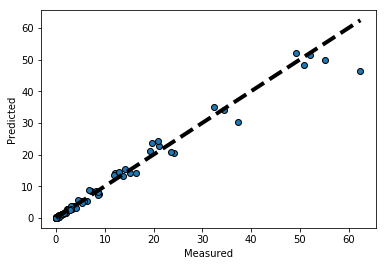

In [34]:
fig, ax = plt.subplots()
ax.scatter(Y_test, predicted_m4, edgecolors=(0, 0, 0))
ax.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [35]:
accuracy_score = m4_rfr.score(X_test, Y_test)
print(accuracy_score)

0.994268428


Much better

In [36]:
m4_rfr.get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)>

In [37]:
m4_rfr.feature_importances_

array([  1.99533670e-03,   4.35058587e-03,   3.07092850e-04,
         3.10552717e-03,   1.28338953e-03,   9.88958068e-01])

In [ ]:
# last one is Fr

In [38]:
mean_squared_error(predicted_m4, Y_test)

4.8662761612903225

MSE for the Random Forest Regressor is 4.87.  Over 10 times better than the non-ensemble methods.
It can be further improved using hyperparameter tuning with GridSearchCV.

Next, let's try  __automatic non-linear regression -- the MARS technique__.  Most of the MARS implementations are closed source, and the name MARS is a trade mark.

The most popular open source implementation is Earth.  It needs to be installed separately -- see the imports section.

In [39]:
t = X.values # get a copy of Yacht data X as an NumPy array

Forward Pass
-------------------------------------------------------------------
iter  parent  var  knot  mse         terms  gcv      rsq    grsq   
-------------------------------------------------------------------
0     -       -    -     229.094225  1      230.589  0.000  0.000  
1     0       5    -1    78.751275   2      80.572   0.656  0.651  
2     1       5    -1    17.107310   3      17.794   0.925  0.923  
3     2       5    -1    3.764536    4      3.981    0.984  0.983  
4     3       5    -1    2.522333    5      2.713    0.989  0.988  
5     3       1    -1    1.692485    6      1.851    0.993  0.992  
6     2       1    -1    1.344672    7      1.496    0.994  0.994  
7     3       0    -1    1.156851    8      1.309    0.995  0.994  
-------------------------------------------------------------------
Stopping Condition 2: Improvement below threshold

Pruning Pass
------------------------------------------------
iter  bf  terms  mse     gcv      rsq    grsq   
---------

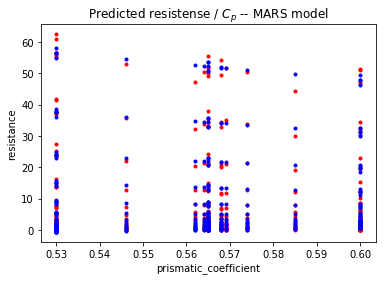

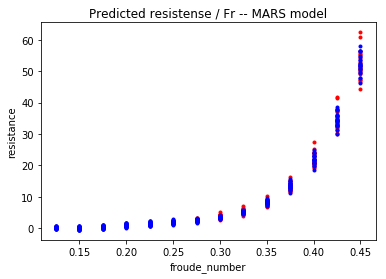

In [40]:
#Fit an Earth model (Multivariate adaptive regression splines)
model = Earth(max_degree=4)
model.fit(X,Y)

predicted = cross_val_predict(model, X, Y, cv=10)

#Print the model
print(model.trace())
print(model.summary())

#Plot the model
y_hat = model.predict(X)
plt.figure()
plt.plot(t[:,1],Y,'r.')
plt.plot(t[:,1],y_hat,'b.')
plt.xlabel('prismatic_coefficient')
plt.ylabel('resistance')
plt.title('Predicted resistense / $C_p$ -- MARS model')
plt.show()

plt.figure()
plt.plot(t[:,5],Y,'r.')
plt.plot(t[:,5],y_hat,'b.')
plt.xlabel('froude_number')
plt.ylabel('resistance')
plt.title('Predicted resistense / Fr -- MARS model')
plt.show()

In [41]:
print(model.summary())

Earth Model
--------------------------------------------------------------------------------------
Basis Function                                                   Pruned  Coefficient  
--------------------------------------------------------------------------------------
(Intercept)                                                      No      32.7614      
froude_number                                                    No      -660.016     
froude_number*froude_number                                      No      3984.09      
froude_number*froude_number*froude_number                        No      -12205.2     
froude_number*froude_number*froude_number*froude_number          No      16878.4      
prismatic_coefficient*froude_number*froude_number*froude_number  No      -4456.11     
prismatic_coefficient*froude_number*froude_number                No      1403.91      
center_of_buoyancy*froude_number*froude_number*froude_number     No      6.69123      
-------------------------------

In [42]:
print(model)

Earth(allow_linear=None, allow_missing=False, check_every=None,
   enable_pruning=True, endspan=None, endspan_alpha=None, fast_K=None,
   fast_h=None, feature_importance_type=None, max_degree=4, max_terms=None,
   min_search_points=None, minspan=None, minspan_alpha=None, penalty=None,
   smooth=None, thresh=None, use_fast=None, verbose=0, zero_tol=None)


The above coefficients from the MARS model looks similar to the results from [\[5\]](#references).  They use MATLAB stepwiselm() -- a functionality missing from the SKlearn

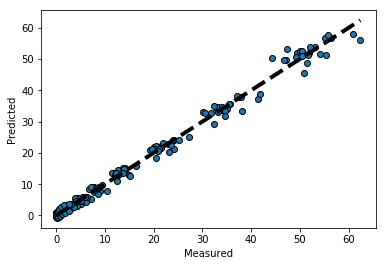

In [43]:
# Plot Cross-Validated Predictions for the MARS model
fig, ax = plt.subplots()
ax.scatter(Y, predicted, edgecolors=(0, 0, 0))
ax.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

Much better than linear regression

In [44]:
accuracy_score = model.score(X_test, Y_test)
print(accuracy_score)

0.993854567995


MSE for the MARS model is 1.16 (the table from print(model.summary()) above).
The best so far.

## Discussion and conclusion

The model based on automatic non-linear regression -- Multivariate adaptive regression splines gives the best results (smallest MSE) on the Yacht Hydrodynamics Data Set, closely followed by scikit-learn's Random forest regressor.

It would be interesting to compare the results to the ones from [\[5, 8\]](#references) as a future work.  They are based on linear regression model using stepwise regression and ANN respectively.

Armed with sufficient domain knowledge, we could compare to a CFD and actual detailed geometry, like [\[11\]](#references).

As an extension to the above project, and with B-spline knowledge one could combine [\[7\]](#references) and  [\[12\]](#references) into a model that extends scikit-learn with B-spline features. 



<a id='references'></a>
## References

[0]: Yacht Hydrodynamics Data Set, UCI Machine Learning Repository https://archive.ics.uci.edu/ml/datasets/Yacht+Hydrodynamics 

[1]: Froude number, From Wikipedia https://en.wikipedia.org/wiki/Froude_number

[2]: Ship resistance and propulsion, From Wikipedia https://en.wikipedia.org/wiki/Ship_resistance_and_propulsion

[3]: Prediction of Resistance and Propulsion Power of Ships, DTU project report, 2013
https://www.danishshipping.dk/en/policy/klimapolitik/beregningsvaerktoejer/download/Basic_Model_Linkarea_Link/163/wp-2-report-4-resistance-and-propulsion-power.pdf

[4]: Shedden, K., University of Michigan, Course Statistics 504, Basis functions in regression
http://dept.stat.lsa.umich.edu/~kshedden/Courses/Stat504/posts/basis/basis/


[5]: Ciaburro, Giuseppe, MATLAB for Machine Learning, pp. 305-306
https://books.google.bg/books?id=gJZGDwAAQBAJ&pg=PA299&lpg=PA299&dq=Sailboat+Data+Predicting+residuary+resistance&source=bl&ots=hWp9EWikVI&sig=BAHSFCPnuz41lFFYDnoyy_9fRi4&hl=en&sa=X&ved=0ahUKEwjL1dHx1pPaAhUNSJoKHRIOB5QQ6AEIZjAH#v=onepage&q=Sailboat%20Data%20Predicting%20residuary%20resistance&f=false

[6]: Ship hull 
https://en.wikipedia.org/wiki/Hull_(watercraft)#History


[7]: MMesch, Robust B-Spline regression with scikit-learn
https://gist.github.com/MMesch/35d7833a3daa4a9e8ca9c6953cbe21d4 and article
http://pythology.blogspot.bg/2017/05/robust-fourier-transformation-with.html


[8]: Lopez, R., Yacht hydrodynamics modeling https://www.neuraldesigner.com/learning/examples/yacht_hydrodynamics_modeling

[9]: AFIT Data Science Lab R Programming Guide 
https://afit-r.github.io/ann_regression


[10]: Delft Systematic Yacht Hull Series (DSYHS) Database Website Manual
http://dsyhs.tudelft.nl/Manual%20DSYHS.pdf


[11]: Kleijweg, N., resistance prediction for high performance sailing yachts https://www.slideshare.net/NielsKleijweg/kleijweg-resistance-prediction-for-high-performance-sailing-yachts

[12]: Stebbing, R.V., B-spline Regression: A repository providing the code necessary to fit explicit uniform B-splines of any degree to unstructured 2D/3D/ND point data.
https://github.com/rstebbing/bspline-regression

## Backup

from work-in-progress versions -- not used above


In [4]:
# from MMesch, Robust B-Spline regression with scikit-learn 
# https://gist.github.com/MMesch/35d7833a3daa4a9e8ca9c6953cbe21d4
# 
class BSplineFeatures(TransformerMixin):
    def __init__(self, knots, degree=3, periodic=False):
        self.bsplines = get_bspline_basis(knots, degree, periodic=periodic)
        self.nsplines = len(self.bsplines)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        nsamples, nfeatures = X.shape
        features = np.zeros((nsamples, nfeatures * self.nsplines))
        for ispline, spline in enumerate(self.bsplines):
            istart = ispline * nfeatures
            iend = (ispline + 1) * nfeatures
            features[:, istart:iend] = si.splev(X, spline)
        return features



In [5]:
# from MMesch, Robust B-Spline regression with scikit-learn 
# https://gist.github.com/MMesch/35d7833a3daa4a9e8ca9c6953cbe21d4
# 
def get_bspline_basis(knots, degree=3, periodic=False):
    """Get spline coefficients for each basis spline."""
    nknots = len(knots)
    y_dummy = np.zeros(nknots)

    knots, coeffs, degree = si.splrep(knots, y_dummy, k=degree,
                                      per=periodic)
    ncoeffs = len(coeffs)
    bsplines = []
    for ispline in range(nknots):
        coeffs = [1.0 if ispl == ispline else 0.0 for ispl in range(ncoeffs)]
        bsplines.append((knots, coeffs, degree))
    return bsplines


http://www.chegg.com/homework-help/questions-and-answers/questions-sailboat-data-predicting-residuary-resistance-sailing-yachts-initial-design-stag-q11647225
